# Amazon Fine Food Reviews Analysis - Logistic Regression


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

In this assignment I perform,

1. All the Data cleaning and Text Preprocessing steps on the Amazon reviews.

Once the data cleaning is done, we perform the following steps:


# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [227]:

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

import os

In [3]:
# Loading the data
# using the SQLite Table to read data.
con = sqlite3.connect('I:\Python\database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Exploratory Data Analysis

## [2.1]  Data Cleaning: Deduplication 

It was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Hence in order to reduce redundancy it's better to eliminate the rows having same parameters.

The method used to perform deduplication is that, we first sort the data according to ProductId and then just keep the first similar product review and delete the others. This method ensures that there is only one representative for each product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis = 0, ascending = True, inplace=False, kind='quicksort', na_position='last')

#Dropping duplicates. It says that find duplicates with {'UserId', 'ProfileName', 'Time', 'Text'} values same. Then it is a duplicate
# By using drop_duplicate function we just keep the first product Id of the duplicates and remove the remaining.
final_data = sorted_data.drop_duplicates(subset = {'UserId', 'ProfileName', 'Time', 'Text'}, keep = 'first', inplace = False)

# Now it prints total reviews after removing duplicates.
print('Total number of reviews in the dataframe after removing duplicates :', final_data.shape)

Total number of reviews in the dataframe after removing duplicates : (364173, 10)


In [5]:
# HelpfulnessNumerator should always be less than HelpfulnessDenominator. 
# So check if any reviews have HelpfulnessNumerator greater than HelpfulnessDenominator and remove them
final_data = final_data[final_data.HelpfulnessNumerator <= final_data.HelpfulnessDenominator]

final_data.shape

(364171, 10)

In [6]:
#Checking to see how much % of data still remains

(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

In [7]:
# Lets see how many total reviews left
print(final_data.shape)

#How many positive and negative reviews are present in the dataset?
final_data['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

#### Observation:-

From the above output we can see that there are many positive reviews and fewer negative reviews.

# 3. Text Preprocessing :- Stemming, Stop-word removal and Lemmatization

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and perform K-NN on Featurizations.

1. By removing stop-words, BoW vector will be small and more meaningful
2. Lemmatization is a process of breaking a sentence into words. It is language and context dependent

Hence in the Preprocessing phase we do the following in the order below:-

1. Remove all URL's 
2. Remove all tags from the strings
3. Expanding English language contractions  like, you've -> you have
4. Remove any punctuations or limited set of special characters like , or . or # etc.
5. Check if the word is made up of english letters and is not alpha-numeric
6. Remove words with numbers 
7. Remove spacial characters
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the words to lowercase
6. Remove Stopwords
7. Finally Stemming the words which are related, to their stem form/root/base form (Snowball stemmer is used as it is obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

## [3.1]  Preprocessing Review Text

In [8]:
# printing some random reviews
sent_0 = final_data['Text'].values[0]
print(sent_0)
print("="*50)

sent_6 = final_data['Text'].values[6]
print(sent_6)
print("="*50)

sent_100000 = final_data['Text'].values[100000]
print(sent_100000)
print("="*50)

sent_200500 = final_data['Text'].values[200500]
print(sent_200500)
print("="*50)

sent_364000 = final_data['Text'].values[364000]
print(sent_364000)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
Can't say anything bad about Sugar in the Raw.  I like i

In [9]:
# Remove urls from text ----  https://stackoverflow.com/a/40823105/4084039
import re
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_100000 = re.sub(r"http\S+", "", sent_100000)
sent_200500 = re.sub(r"http\S+", "", sent_200500)
sent_364000 = re.sub(r"http\S+", "", sent_364000)

print(sent_100000)


Can't say anything bad about Sugar in the Raw.  I like it better than the other "natural" sugars. Better consistency and - I know it doesn't matter - but better color. Unfortunately, one of the "natural" paper bags got torn a bit in the box.  It didn't look like the box was damaged so I can't tell how it happened, but it was sort of pain to clean up half a bag that spilled all over the inside of the box and our kitchen when I opened it.  Not sure what the solution is and I'd order it again, but if it happens again, I'd switch to one of the brands that ship in an unnatural plastic bag.


In [10]:
# Removes all tags from a string --- https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_6, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_100000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_200500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)


this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.First, this book taught him the months of the year.Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
Can't say anything bad about Sugar in the Raw.  I like it better than the other "natural" su

In [11]:
# Expanding English language contractions  like, you've -> you have,  aren't -> are not
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"doesn\'t", "does not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
sent_100000 = decontracted(sent_100000)
print(sent_100000)
print("="*50)

Ca not say anything bad about Sugar in the Raw.  I like it better than the other "natural" sugars. Better consistency and - I know it does not matter - but better color. Unfortunately, one of the "natural" paper bags got torn a bit in the box.  It did not look like the box was damaged so I can not tell how it happened, but it was sort of pain to clean up half a bag that spilled all over the inside of the box and our kitchen when I opened it.  Not sure what the solution is and I would order it again, but if it happens again, I would switch to one of the brands that ship in an unnatural plastic bag.


In [13]:
# Removes punctuations from strings ---  https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_100000 = re.sub(r'[^\w\s]','', sent_100000)
sent_200500 = re.sub(r'[^\w\s]','', sent_200500)
sent_364000 = re.sub(r'[^\w\s]','', sent_364000)

print(sent_100000)

Ca not say anything bad about Sugar in the Raw  I like it better than the other natural sugars Better consistency and  I know it does not matter  but better color Unfortunately one of the natural paper bags got torn a bit in the box  It did not look like the box was damaged so I can not tell how it happened but it was sort of pain to clean up half a bag that spilled all over the inside of the box and our kitchen when I opened it  Not sure what the solution is and I would order it again but if it happens again I would switch to one of the brands that ship in an unnatural plastic bag


In [14]:
#Remove words with numbers  ---- https://stackoverflow.com/a/18082370/4084039
sent_6 = re.sub("\S*\d\S*", "", sent_6).strip()
print(sent_6)

I set aside at least an hour each day to read to my son  y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to  y/o old to  /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [15]:
#Removes spacial characters --- https://stackoverflow.com/a/5843547/4084039
sent_100000 = re.sub('[^A-Za-z0-9]+', ' ', sent_100000)
print(sent_100000)

Ca not say anything bad about Sugar in the Raw I like it better than the other natural sugars Better consistency and I know it does not matter but better color Unfortunately one of the natural paper bags got torn a bit in the box It did not look like the box was damaged so I can not tell how it happened but it was sort of pain to clean up half a bag that spilled all over the inside of the box and our kitchen when I opened it Not sure what the solution is and I would order it again but if it happens again I would switch to one of the brands that ship in an unnatural plastic bag


In [16]:
# Converting words into lowercase
sent_200500 = sent_200500.lower()
print(sent_200500)


i did some research on just exactly what kind of cinnamon is actually used in this product because i became concerned when i read a few of the reviews eight paragraphs down on the simply organics website they state that they use korintje cinnamomum burmanii to quote the website the most commonly found cinnamon in american kitchens is indonesian cassia it is sourced from higher elevations and is harvested a bit earlier than chinese and vietnamese cinnamons korintje translates as thick quill and is judged for quality based on the part of the tree that is harvested trunk vs branch and on the length of the bark peeled from the tree we bring you the highest quality korintje cinnamon availablebr br so they do use cassia and not the ceylon true cinnamon they also state that cassia and cinnamon are not the same they start with that then they end the product description explaining all the health benefits of true cinnamon not the cassia that they are really selling you i really wish i had known 

In [17]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [18]:
# Combining all the above statements 
from tqdm import tqdm
final_strings = []
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)  # To remove urls from text
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # To remove all tags from an element
    sentence = decontracted(sentence) # Expanding English language contractions  like, you've -> you have,  aren't -> are not
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # removes words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removes special characters
    sentence = sentence.lower()  # Converting words into lowercase
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    final_strings.append(sentence.strip())

100%|██████████| 364171/364171 [03:51<00:00, 1574.81it/s]


In [19]:
final_strings[50000]

'use marinade weekly basis another flavor lawry really good not spicy overwhelming making good marinade everyone even picky kids not like spicy tastes'

In [20]:
# store final_data table into an SQlLite table for future.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [21]:
final_data['CleanedText'] = final_strings 
#final_data['CleanedText'] = final_data['CleanedText'].str.decode("utf-8")
final_data.shape
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...


In [22]:
print(final_data['Score'].value_counts())

positive    307061
negative     57110
Name: Score, dtype: int64


## [3.2]  Preprocessing Reviews Summary

In [23]:
# printing some random reviews
sent_6 = final_data['Text'].values[6]
print(sent_6)
print("="*50)

sent_5000 = final_data['Text'].values[5000]
print(sent_5000)
print("="*50)

sent_50000 = final_data['Text'].values[50000]
print(sent_50000)
print("="*50)

sent_355000 = final_data['Text'].values[355000]
print(sent_355000)
print("="*50)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
late delivered, I paid extra charge for faster delivery but is not delivered on the time i've expected it.
We use marinade on a weekly basis, and this is another flavor from Lawry's that is really good.  Not too spicy or overwhelming, making it a good marinade for everyone (even picky kids who don't like spicy tastes).
Great taste and amazing crunch. If you have never experienced the large/deluxe/fancy peanuts and have only had 

In [24]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_6, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_5000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_50000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_355000, 'lxml')
text = soup.get_text()
print(text)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.First, this book taught him the months of the year.Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
late delivered, I paid extra charge for faster delivery but is not delivered on the time i've expected it.
We use marinade on a weekly basis, and this is another flavor from Lawry's that is really good.  Not too spicy or overwhelming, making it a good marinade for everyone (even picky kids who don't like spicy tastes).
Great taste and amazing crunch. If you have never experienced the large/deluxe/fancy peanuts and have only had Planters or regular "salted in the s

In [25]:
# Expanding English language contractions  like, you've -> you have,  aren't -> are not
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [26]:
sent_6 = decontracted(sent_6)
print(sent_6)
print("="*50)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children is books and this is one of the best. Santa Clause put this under the tree. Since then, we have read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it is a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children is books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak is best.


In [27]:
#remove words with numbers ---- https://stackoverflow.com/a/18082370/4084039
sent_6 = re.sub("\S*\d\S*", "", sent_6).strip()
print(sent_6)

I set aside at least an hour each day to read to my son  y/o). At this point, I consider myself a connoisseur of children is books and this is one of the best. Santa Clause put this under the tree. Since then, we have read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it is a pleasure to read. Well suited to  y/o old to  /><br />Very few children is books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak is best.


In [28]:
#remove spacial character ----- https://stackoverflow.com/a/5843547/4084039
sent_355000 = re.sub('[^A-Za-z0-9]+', ' ', sent_355000)
print(sent_355000)

Great taste and amazing crunch If you have never experienced the large deluxe fancy peanuts and have only had Planters or regular salted in the shell you are in for a wonderful experience The intense taste and solid crunch will keep your hand in the can til they are gone 


In [29]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [30]:
# Performing all the preprocessing steps on Summary data.
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"
from tqdm import tqdm
summary_data = []
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)  # To remove urls from text
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # To remove all tags from an element
    sentence = decontracted(sentence) # Expanding English language contractions  like, you've -> you have,  aren't -> are not
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # removes words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removes special characters
    sentence = sentence.lower()  # Converting words into lowercase
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    summary_data.append(sentence.strip())

100%|██████████| 364171/364171 [02:18<00:00, 2629.56it/s]


In [31]:
summary_data[15550]

'little bitter excellent price'

In [32]:
# store final_data table into an SQlLite table for future.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [33]:
final_data['CleanedSummary'] = summary_data 
final_data.shape
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months


In [34]:
print(final_data['Score'].value_counts())

positive    307061
negative     57110
Name: Score, dtype: int64


# 4. Sample the data from the Dataset

In [35]:
# Taking equal sample of negative and positive reviews each 50000, total 100,000 datapoints
positive_pts = final_data[final_data['Score'] == 'positive'].sample(n=50000)
negative_pts = final_data[final_data['Score'] == 'negative'].sample(n=50000)

# Concatenating both positive and negative points
total_score = pd.concat([positive_pts, negative_pts])
total_score.shape

(100000, 12)

## [4.1]  Time Based Splitting

Generally we do random splitting of entire dataset into train, test, cross validate data. With this method we may not get correct accuracy everytime. With time products change and reviews for the product also change, hence with random splitting we may not get best value/accuracy.

But for Amazon Food Reviews Dataset Time based splitting is better than Random splittng. We can perform Time based splitting only when we have time feature in our dataset. Cross Validate data is used to find best hyper parameter and Test data is used to find accuracy and we train a model on all these.

So Time based splitting gives more accuracy than random splitting, even on the future data when data changes with time. It's preferable to do Time based splitting when time is available.

1. For each review in the dataset there is a timestamp. In Time based splitting, we first sort all the data in the dataset in increasing order(ascending) of time.
2. Now split 70% of data into Train data and remaining 30% of data into test data.


In [36]:
# sorting data using time
total_score['Time'] = pd.to_datetime(total_score['Time'])
total_score = total_score.sort_values(by = 'Time', ascending = True)

In [37]:
# display top 5 rows
total_score.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,1970-01-01 00:00:00.947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movie movie collection filled comedy actio...,great
346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,1970-01-01 00:00:00.951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happens say name three times michael keaten st...,bettlejuicebettlejuicebettlejuice
346078,374383,B00004CI84,A34NBH479RB0E,"""dmab6395""",0,1,positive,1970-01-01 00:00:00.977184000,FUNNY,"I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA...",thought movie funny michael keaton beetlejuice...,funny
138020,149792,B00004S1C6,A3B5QJVM1TLYJG,Dan Crevier,11,12,positive,1970-01-01 00:00:01.003795200,"Nice, bright colors!",I bought these to decorate some dia de los mue...,bought decorate dia de los muertos skulls icin...,nice bright colors
346105,374411,B00004CI84,A1CAA94EOP0J2S,Travis J Smith,4,4,positive,1970-01-01 00:00:01.036022400,Great Comedy,Beetlejuice is the story of ghosts (Alec Baldw...,beetlejuice story ghosts alec baldwin geena da...,great comedy


## [4.2]  Splitting data into Train and Test data

In [38]:
# loading libraries

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.random_projection import sparse_random_matrix
from scipy.sparse import csr_matrix


In [146]:
# splitting the data into train, test data
X = total_score['CleanedText']
Y = total_score['Score']
# X = total data, Y = class labels, X_test and Y_test are test data set of 30%
# Total score is splitted into Train and test data with 70-30 ratio

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)

X_train, Y_train (70000,) (70000,)
X_test, Y_test (30000,) (30000,)


# Logistic Regression:-

Logistic Regression is actually a classification technique. 
Assumption of LR :- Classes/Data are almost/perfectly linearly seperable. So task is to find a plane that seperates the positive points from negative points.

##### Cases of LR:-

Case 1:- For both positive and negative points if Yi W^t Xi>0 ( Yi = +1(positive) and W^t Xi>0 )then the model LR is correctly classifying the point Xi.

Case 2:- If Yi = +1(positive) and W^t Xi<0 then Yi W^t Xi <o , then LR is saying Xi is negative class(-1). Here true class label Yi = +1 and LR = -1, so it is misclassified point.

Case 3:- Yi = -1 (negative class), W^t Xi>0, it means LR is saying Xi is positive point. This is also a case of misclassified point where Yi W^t Xi<0. 

1. We want the classifier to be very good with minimum number of misclassifications or maximum correctly classified points like case 1 ( Yi W^t Xi>0 ) . 

2. Yi W^t Xi = positive ==> Plane as defined by W correctly classifies Xi. We have to maximize it.
    "     = negative ==> Plane incorrectly classifies Xi. We have to minimize it 
          
3. Sometimes outliers impact the model very badly. We can modify model such that outliers does not impact model. We do it using a technique called Squashing.

##### Hyperparameter

Lambda is hyperparameter in Logistic Regression. 

1. If Lambda = 0 , then there is no Regularization term and model will overfit to the training data which means high variance ( Zi goes to infinity )

2. If Lambda = large or infinity, then the training data is not used to find best W. Then model will underfit which means high Bias. There will not be loss term.

3. We can find best Lambda using Cross Validation. Lambda controls overfitting and underfitting.

4. Lambda in LR is a real number, so number of possible values for Lambda are infinity. So one technique to find best lambda is Grid search which is a brute force technique. <br>
5. We draw a plot with  list of lambda values on X-axis and CV error or any other metric like accuracy, log-loss, auc, f1 etc on Y-axis. Based on the plot we can know best lambda. <br>
6. In Logistic Regression C = 1/Lambda. As C increases ---> Overfit.  As C decreases ---> Underfit. 

6. In Grid search there is a problem that, as number of hyper parameters increase, the number of times the model needs to be trained increases exponentially. So Grid search is not good when there are lot of hyper parameters like in deep learning where we have many hyper parameters.

7. So for this reason there is other technique called Random search, where we randomly pick values in the given interval and plot them to pick the best hyper parameter.

8. Random search is good and fast than Grid search when the number of parameters are large. This concept ame from deep learning. All these searching techniques come under Hyper parameter search/optimization.

##### L1 & L2 Regularization:-

1. In most of the problems in Machine Learning, we have to minimize the loss function over training data + regularization term (L1 & L2) . To avoid overfitting of training data, we are introducing Regularization terms ( L1 & L2 ).

2. Both L1 and L2 reg terms work similarly but L1 has an advantage of sparsity over L2. L1 creates sparsity. Solution of LR, which is finding optimal W (W*) is said to be sparse if many Wi's in vector W are zeros. This is called sparsity in LR.

3. If we use L1 reg in LR, then all the words of un-important/less-important features becomes zero. If we use L2 reg then the words of less-important features becomes a small but not zero.

4. So L1 regularization is often used in LR for sparsity, when we want all the weights of un-important features to become zero.

5. When we use two hyper parameters L1 & L2 in LR then it is called Elastic-net formulation of LR.

6. 0-1 Loss function:- If a loss-function has 1 for incorrectly classified points and 0 for correctly classified points.

7. As 0-1 loss function is not-differentiable, we can approximate it. Such approximation is logistic-loss and by doing this we  get logistic regression. So one approximation to 0-1 loss is logistic loss. 

8. By haivng different loss functions like logistic loss, hinge loss, exponential loss, squared loss etc, we can get different algorithms like Logistic regression, SVM, AdaBoost, Linear regression etc.  


In Logistic Regression it is mandatory to perform feature standardization before training the model on the data because as there are different features with different scales, the scale of the feature could impact the result.

Feature/column standardization is also called as mean-centering and scaling.

##### Feature Importance:-

1. If all the features are independent then we can get feature importance.
2. In K-NN we got feature impotance using technique called forward feature selection, as the model does give this inherently.
3. In Naive Bayes, we got feature importance using conditional probabilities P(Xi|Y=+1). Using this we got features/words which are important to determine class labels.
4. In Logistic regression we can use Wj's( Absolute Weights value of features ) to determine feature importance. 
5. With feature importance we can get an additional benifit in LR which is Model Interpretability, using which we cna tell the model is sensible or not.

##### Collinearity or Multicollinearity:-

1. In this case features are not independent and feature weights cannot be used as feature importance values.
2. When we have 2 features which can be represented in a linear way where one feature is represented in terms of another features by using two constants Alpha and Beta then those features are called collinear and it is called collinearity.
3. Collinearity across multiple features is called Multicollinearity.
4. If features are collinear then weight vector can change arbitarily and so weights of the features cannot be used for feature importance. 
5. So to decide whether weights can be used for feature importance or not, first we have to determine if features are multicollinear or not. So a technique for this is Pertubation technique.
6. Pertubation means to shake the values a little by adding small epsilon which is a small noise or error term. This should be done after column standardization. 
7. Before pertubation we have to train the model and we get weight vectors and after pertubation again we have to train the new model again to get new weight values. If both the before and after pertubation values differ significantly, then we can conclude the features are collinear. Then we  can't use weight values as feature importance.
8. But if they differ slightly then we can use weight values for feature importance.
9. So checking for multicollinearity is very important in real world

# Featurizations

## 5. Bag of Words (BoW)

1. It is one of the simple technique to convert text to vector.
2. Constructs a dictionary with set of all the unique words in the reviews.
3. Next construct a vector of size 'd' for d-unique words. Each index corresponds to one word in the dictionary.
4. Each word is different dimension in d-dim vector and each cell in vector corresponds to number of times the corresponding word occurs in review.
5. There are different BoW. One is Binary BoW - it says that, instead of specifying the count of number of occurances, it will specify whether the word occurs or not. This is also called boolean BoW.
6. BoW can be said as number of differing words. BoW is applied after all the preprocessing and data cleaning steps. It just says whether a word is present or not in the text. We get set of words

In [40]:
# BoW
# Creating a variable count_vect of CountVectorizer type and inititalizing it.
count_vect = CountVectorizer() #in scikit-learn

# X_train and X_test data is converted vector and is stored in X_train_bow and X_test_bow
X_train_bow = count_vect.fit_transform(X_train)
X_test_bow = count_vect.transform(X_test)

# sparse matrix - most of the values of any row in a matrix are zero.Such matrices are called sparse matrix and row in the matrix is sparse vector
# The more sparse a matrix is, the more efficient is sparse matrix representation technique
print("the type of count vectorizer ", type(X_train_bow))# gets the type of X_train_bow which is a matrix
print("the type of count vectorizer ", type(X_test_bow))# gets the type of X_test_bow which is a matrix

# gets the shape of the matrix
print(X_train_bow.get_shape()) 
print(X_test_bow.get_shape()) 

print("the number of unique words are ", X_train_bow.get_shape()[1])
print("the number of unique words are ", X_test_bow.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
(70000, 95408)
(30000, 95408)
the number of unique words are  95408
the number of unique words are  95408


### [5.1]  Performing GridSearch CV on BoW using f1-score as metric and L2 regularization

In [41]:
#code source--- http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
# Performing L2 Regularization
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# GridsearchCV trains the model on these parmters to find the best one
tuned_parameters = [{'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}] # List of parameters for hyperparameter tuning

#Using GridSearchCV. Default regularizer is L2. We can change it to L1 using penalty = 'L1', Giving list of parameters for tuning
# to find best hyperparameter. Now using GridSearchCV, LR model is trained on these list of hyperparameters/values of C.
# Scoring is taken as f1_macro.
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_macro', cv=5)
model.fit(X_train_bow, Y_train)


# model.best.estimator prints the best hyperparameter we are looking for and it prints the remaining parameters default 
# as they are, because we performaed GridSearch only for best hyperparameter or C.
print(model.best_estimator_) 


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [42]:
# to get the score on test data 
print(model.score(X_test_bow, Y_test))  


0.8858661142586597


In [43]:
# Predicting model on test to find f1-score for L2 Regularization
from sklearn.metrics import f1_score
logisitc_regression_optimal = LogisticRegression(C = 0.1)

# fitting the model
logisitc_regression_optimal.fit(X_train_bow, Y_train)

# predict the response
pred_bow = logisitc_regression_optimal.predict(X_test_bow)

# evaluate accuracy. Using f1_score as metric to measure accuracy
test_f1_bow = f1_score(Y_test, pred_bow, pos_label = 'positive', average = 'binary') * float(100)
print('\nThe test f1-score of the Logistic regression classifier for C = 0.1 is %f%%' % (test_f1_bow))


The test f1-score of the Logistic regression classifier for C = 0.1 is 88.561502%


In [44]:
# Finding test error
test_error_bow = (1 - f1_score(Y_test, pred_bow, pos_label = 'positive', average = 'binary')) 
print("Test Error for Logistic regression BoW is %.3f%%" % (test_error_bow))

Test Error for Logistic regression BoW is 0.114%


### [5.2]  Plotting the performance of CV and Train scores for L2 regularization

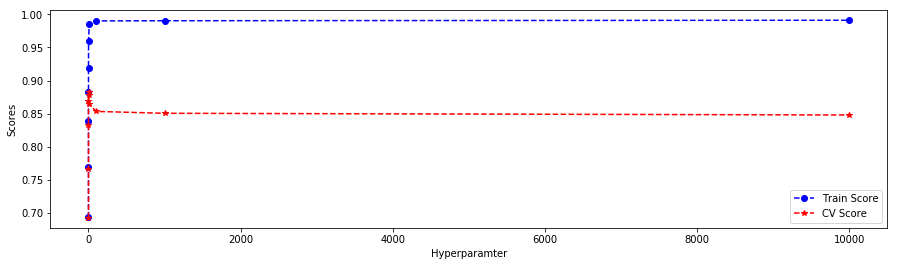

The CV f1-score for each alpha value is :  [0.693 0.767 0.834 0.869 0.882 0.879 0.864 0.853 0.851 0.848]
the Train score for each alpha value is :  [0.693 0.769 0.839 0.883 0.919 0.96  0.986 0.99  0.99  0.991]


In [45]:
# Plotting the performance of CV and Train scores which we got through L2 regularization

plt.figure(figsize=(15,4))
plt.xlabel('Hyperparamter')
plt.ylabel('Scores')
plt.plot(model.cv_results_['param_C'].data.astype(np.float64), model.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model.cv_results_['param_C'].data.astype(np.float64), model.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV f1-score for each alpha value is : ", np.round(model.cv_results_['mean_test_score'],3))

print("the Train score for each alpha value is : ", np.round(model.cv_results_['mean_train_score'],3))


### [5.3]  Plotting ROC curve and finding AUC score for BoW

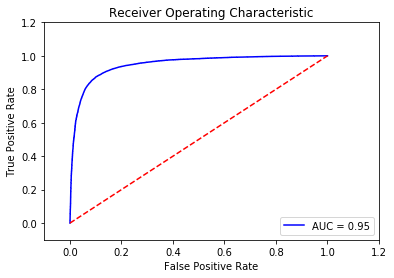

In [46]:
# ROC curve and AUC for BoW
from sklearn.metrics import roc_curve, auc
# Predicting the probabilities of test data as ROC curve needs probabilities to plot
Y_prob = model.fit(X_train_bow, Y_train).predict_proba(X_test_bow)
# Giving actual values(Y_test) and predicted probabilities Y_prob
# we need to calculate the fpr and tpr for all thresholds of the classification 
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob[:, 1], pos_label = 'positive')
# We calculate the AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)
    
# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation:- 
From the ROC plot, we got the accuracy of 0.95, which shows that the classifier is working well and predicts correctly.

### [5.4]  Confusion matrix for BoW

In [47]:
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred_bow) # finding confusion matrix between true data and predicted data
print(cm)

[[13321  1676]
 [ 1748 13255]]


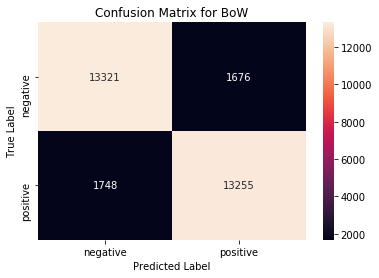

In [48]:
# plot confusion matrix for BoW
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test, pred_bow) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Confusion Matrix for BoW")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observations:-

A Confusion matrix is a table that is often used to describe the performance of the classification model on a set of test data. It is also one of the metric to measure accuracy of the model.

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. The confusion matrix shows how the classification model is confused when it makes predictions.

The above confusion matrix is didvided into 2 classes positive and negative with True values and predicted values.

    TN - 13321  FP - 1676

    FN - 1748 , TP - 13255

    where

    TN - True negative, True value is negative, and is predicted value is negative.
    FP - False positive, True value is negative, but is predicted as positive.
    FN - False negative, True value is positive, but is predicted as negative
    TP - True positive, True value is positive, and is predicted value is positive.

1. There are total of 30000 points being tested against the model. Out of all values, the classifier/model predicted points as positive 14,931 times and negative 15,069 times.
2. But in true values(test data), the positive points are 15,003 and negative points are 14,997.
3. The diagonal values (13321 negative points, 13255 positive points) in the confusion matrix are correctly predicted values by the classifier.



#### Finding TPR, FPR, TNR, FNR values

1.  TPR tells, when it's actually yes and how often does classifier predict yes

    TPR = TP/(TP+FN) = 13321/15003 = 0.8878. TPR also known as Recall 


2.  FPR tells, when it's actually no, how often does classifier predict yes

    FPR = FP/(FP+TN) = 1676/14997 = 0.1117


3.  TNR tells, when it's actually no, how often does classifier predict no

    TNR = TN/(TN+FP) = 13321/14997 = 0.8882


4.  FNR tells, When it's actually yes, how often does it predict no

    FNR = FN/(FN+TP) = 1748/15003 = 0.1165



### [5.5] Classification report for BoW:-

1.  Classification Rate/Accuracy:

    Accuracy = (TP + TN) / (TP + TN + FP + FN)


2.  Recall:- It tells, when the points are positive and how often they are predicted positive.

    Recall = TP / (TP + FN)


3.  Precision:- It tells, when the model predicted positive and how often is it correct.

    Precision = TP / (TP + FP)


4.  f1-score = (2 Recall Precision) / (Recall + Presision)


5.  Support is the total number of points in each class (positive and negative)



In [49]:
# calculate the classification report for BoW
from sklearn.metrics import classification_report 
 
print('Accuracy Score:', accuracy_score(Y_test, pred_bow)) 
print('Report:')
print(classification_report(Y_test, pred_bow)) 


Accuracy Score: 0.8858666666666667
Report:
             precision    recall  f1-score   support

   negative       0.88      0.89      0.89     14997
   positive       0.89      0.88      0.89     15003

avg / total       0.89      0.89      0.89     30000



#### Observation:-

In case of BoW Logistic Regression, accuracy, f1-score, precision all gave same score of 88% accuracy for C = 0.1 .


### [5.6] Feature Importance for BoW

To find feature Importance, first sort all the words based on its absolute value of feature weight score, where top words have more weight. So for positive class or negative class, we have to find words with highest absolute weight value, as they are most informative/important features or words for determining whether the text/sentence belongs to positive class or negative class.

If the weight value of a word is positive and large then probability that the word/feature belongs to positive class increases. If the weight value of a word is negative and large then probability that the word/feature belongs to negative class increases.

So we can say that, in Logistic regression we can find feature importance based on absolute value of feature weights.


In [50]:
# Just printing feature names
feature_names = np.array(count_vect.get_feature_names())

model = LogisticRegression()
model.fit(X_train_bow, Y_train)

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['worst' 'disappointing' 'mediocre' 'disappointment' 'rip' 'terrible'
 'awful' 'tasteless' 'horrible' 'sadly']

Largest Coefs: 
['pleasantly' 'hooked' 'hesitation' 'worry' 'skeptical' 'downside'
 'delicious' 'addicting' 'complaint' 'beat']



In [51]:
# Reference:--  https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
# Printing feature names along with weights.

def show_most_informative_features(vectorizer, model, n=10): # To print top 10 features 
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(model.coef_[0], feature_names)) # fns- feature names
    top = zip(coefs_with_fns[:-(n + 1):-1], coefs_with_fns[:n]) 
    for (coef_1, fn_1), (coef_0, fn_0) in top:  # For positive and negative classes to print top 10 features
        print("\t%.4f \t%-15s \t\t%.4f \t%-15s" % (coef_1, fn_1, coef_0, fn_0))
show_most_informative_features(count_vect, model)


	3.1222 	pleasantly      		-3.3910 	worst          
	2.5635 	hooked          		-3.2043 	disappointing  
	2.1085 	hesitation      		-2.9052 	mediocre       
	2.0813 	worry           		-2.7286 	disappointment 
	2.0781 	skeptical       		-2.3921 	rip            
	2.0314 	downside        		-2.3768 	terrible       
	1.9791 	delicious       		-2.3611 	awful          
	1.9647 	addicting       		-2.3137 	tasteless      
	1.8935 	complaint       		-2.1883 	horrible       
	1.8683 	beat            		-2.1213 	sadly          


### [5.7]  Pertubation Test

1. If we can represent one feature in terms of other feature by using conctants like alpha and beta then those features are said to be collinear..
2. Multicollinearity means, collinearity across multiple features.
3. If features are collinear or multicollinear then weight vector can change arbitarily. Wj cannot be used for feature importance.  So to determine if we can use Wj for feature importance or not, first we have to determine if features are multicollinear or not. 
4. So the technique used for the above process is, Pertubation technique. Pertubation means to shape it a little.
5. For every data point in the dataset, we have to add small epsilon(error/noise). We can generate this noise from random variable with mean 0 and small variance(say, 0.01).
6. We are pertubating the values by adding small noise/error.
7. Before pertubation/adding noise, we have to compute weight vector W by training logistic regression. After pertubation again train logistic regression and compute W'(another weight vector).
8. If the values of W and W' differs drastically/significantly, then we can conclude that the features are collinear and we can't use Wj(weights) as feature importance. 
9. If the values don't differ much or differ slightly then we use weights as feature importance.
10. So we should check for multicollinearity to find whether the absolute values of Wj's can be used for feature importance or not.
11. If we can't use absolute values of Wj for Feature importance, we have other technique like forward feature selection, we cna use this.

In [52]:
# Training the model on train data and getting the weights before adding noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l2')
clf.fit(X_train_bow, Y_train)
Y_pred = clf.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print(clf.coef_.shape)

Accuracy on test set: 88.587%
(1, 95408)


In [53]:
#Weights before adding random noise
from scipy.sparse import find

weights = find(clf.coef_)[2]
print(weights[:50])

[ 5.67236618e-02  1.09378867e-01  5.08532246e-03  3.86515471e-04
  8.02510742e-05 -5.37684429e-03 -1.83736286e-04  6.86552884e-03
 -3.98349658e-02 -3.93143427e-02  5.35116486e-06  4.54244990e-02
 -9.88489618e-03 -1.07336568e-02 -7.84500998e-02  8.78910565e-03
  1.09632605e-02  7.00579124e-02 -2.75654655e-04  4.10476284e-03
 -2.99893376e-03  4.17871643e-02 -3.33125342e-02  1.23943344e-03
 -2.99671285e-02  1.67767914e-01  1.06601492e-02 -1.44212976e-03
 -4.04749778e-02  4.82633888e-02  7.96055263e-02 -7.38528449e-02
 -3.60451933e-02 -2.88328335e-02 -1.46434542e-03 -3.36971093e-02
 -1.44793347e-02  2.32682622e-03  2.24959294e-02  7.23991886e-02
  5.00272840e-02  6.44680832e-04  1.02251626e-02 -6.33907696e-02
 -1.11764418e-03  3.57830693e-03 -1.10309373e-01  9.85951046e-05
  6.89636474e-02 -1.48988502e-01]


In [54]:
#Adding Random noise 

X_train_bow_t = X_train_bow.copy()
#epsilon = 0.0001
epsilon = np.random.normal(0,0.0001)  # (mean, std) 

X_train_bow_t.data = epsilon + X_train_bow_t.data

In [55]:
print(X_train_bow.shape)
print(X_train_bow_t.shape)
print(X_train_bow_t.data.shape)

(70000, 95408)
(70000, 95408)
(2370399,)


In [56]:
#Training the model on train data again, after having random noise

clf = LogisticRegression(C= 0.1, penalty= 'l2')
clf.fit(X_train_bow_t, Y_train)
Pertubated_weights = clf.coef_
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print(Pertubated_weights.shape)

Accuracy on test set: 88.587%
(1, 95408)


In [57]:
#Weights after adding random noise
from scipy.sparse import find

weights2 = find(clf.coef_)[2]
print(weights2[:50])

[ 5.67311816e-02  1.09378402e-01  5.08499588e-03  3.86459098e-04
  8.04885750e-05 -5.37764299e-03 -1.83613724e-04  6.86500011e-03
 -3.98351799e-02 -3.93126421e-02  5.11680312e-06  4.54249925e-02
 -9.88296971e-03 -1.07336600e-02 -7.84520054e-02  8.77894874e-03
  1.09631856e-02  7.00632720e-02 -2.75435158e-04  4.10431662e-03
 -2.99949625e-03  4.17886894e-02 -3.33119578e-02  1.23865637e-03
 -2.99674769e-02  1.67776666e-01  1.06627600e-02 -1.44176577e-03
 -4.04742613e-02  4.82660785e-02  7.96110830e-02 -7.38480014e-02
 -3.60427439e-02 -2.88341336e-02 -1.46433338e-03 -3.37022345e-02
 -1.44777032e-02  2.32714298e-03  2.24964861e-02  7.24052581e-02
  5.00311559e-02  6.44662577e-04  1.02216979e-02 -6.33942330e-02
 -1.11775985e-03  3.57783196e-03 -1.10312883e-01  9.88004630e-05
  6.89644046e-02 -1.48996587e-01]


In [58]:
print(weights.size)

95408


In [59]:
print(Pertubated_weights.size)

95408


In [60]:
weights_difference = (abs(weights - weights2)/abs(weights)) * 100

In [61]:
print(weights_difference)

[1.32568410e-02 4.25858549e-04 6.42204582e-03 ... 4.38978607e+01
 1.93342920e-03 2.20313060e-03]


In [62]:
sortWeightsDiff = sorted(weights_difference, reverse = True)

In [63]:
sortWeightsDiff

[4038.723518856621,
 4038.723518856621,
 2521.375525987859,
 2057.602246035667,
 2057.602246035667,
 2057.602246035667,
 2057.602246035667,
 2057.602246035667,
 2057.602246035667,
 2057.602246035667,
 2057.602246035667,
 2057.602246035667,
 2057.602246035667,
 2057.534445899895,
 2057.5005458320506,
 1950.3944601471367,
 1950.3944601471367,
 1950.3944601471367,
 1950.3944601471367,
 1950.3944601471367,
 1950.3944601471367,
 1573.8400736525898,
 1573.8400736525898,
 1472.6616824497353,
 1472.6616824497353,
 1472.6141413066728,
 1264.21353151103,
 1264.21353151103,
 1231.9218473887922,
 1231.9218473887922,
 1231.9218473887922,
 1139.4861106946603,
 1139.4861106946603,
 1097.1720877802454,
 1055.9770605181525,
 1004.1301481772413,
 990.8072690463243,
 990.8072690463243,
 990.8072690463243,
 990.8072690463243,
 990.4718579872032,
 990.4718579872032,
 973.698575392056,
 894.915055126087,
 767.4277159121979,
 703.4467123270138,
 703.4467123270138,
 703.4467123270138,
 703.4467123270138,
 703

In [64]:
len(sortWeightsDiff)

95408

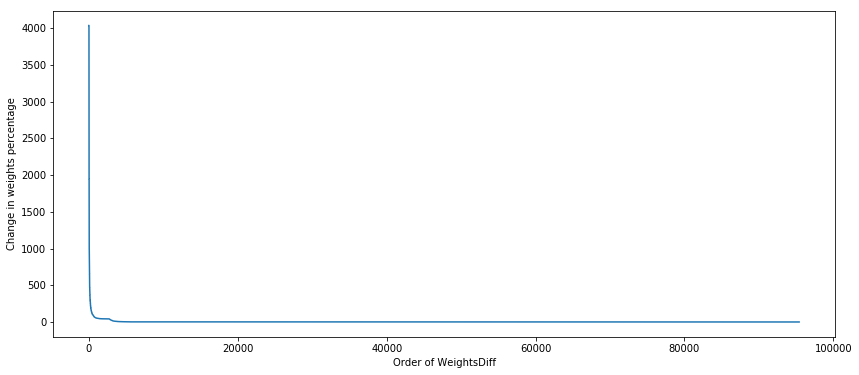

In [66]:
#Plotting the Order of WeightsDiff vs Change in weights percentage
# To find the tau value which can be used as threshold value to find the multicollinear features whose percentages changed drastically.
plt.figure(figsize=(14,6))
plt.plot([x for x in range(95408)], sortWeightsDiff)
plt.xlabel("Order of WeightsDiff")
plt.ylabel("Change in weights percentage")
plt.show()


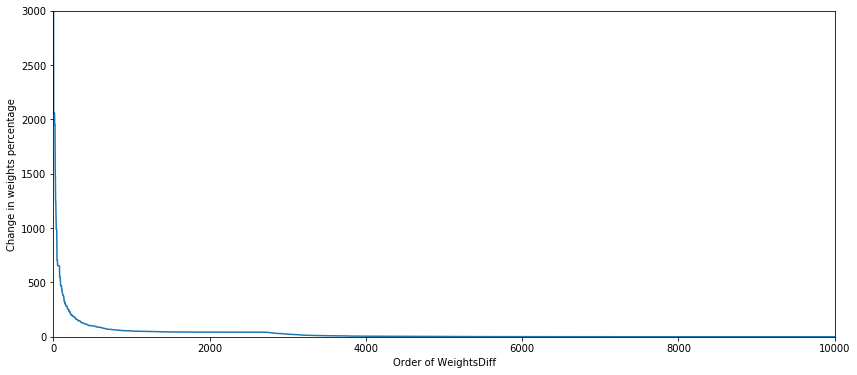

In [67]:
# To observe the values more clearly and find tau value as a threshold
plt.figure(figsize=(14,6))
plt.plot([x for x in range(95408)], sortWeightsDiff)
plt.xlabel("Order of WeightsDiff")
plt.ylabel("Change in weights percentage")
plt.ylim(0,3000)
plt.xlim(0,10000)
plt.show()


#### Observation:- 
By observing the above plot, we can know the threshold tau value as 250 (found on y-axis). There are around 250 features whose % change is more than tau 250.

In [69]:
#Printing those features whose % change is more than tau value which is 250
sortWeightsDiff[0:250]

[4038.723518856621,
 4038.723518856621,
 2521.375525987859,
 2057.602246035667,
 2057.602246035667,
 2057.602246035667,
 2057.602246035667,
 2057.602246035667,
 2057.602246035667,
 2057.602246035667,
 2057.602246035667,
 2057.602246035667,
 2057.602246035667,
 2057.534445899895,
 2057.5005458320506,
 1950.3944601471367,
 1950.3944601471367,
 1950.3944601471367,
 1950.3944601471367,
 1950.3944601471367,
 1950.3944601471367,
 1573.8400736525898,
 1573.8400736525898,
 1472.6616824497353,
 1472.6616824497353,
 1472.6141413066728,
 1264.21353151103,
 1264.21353151103,
 1231.9218473887922,
 1231.9218473887922,
 1231.9218473887922,
 1139.4861106946603,
 1139.4861106946603,
 1097.1720877802454,
 1055.9770605181525,
 1004.1301481772413,
 990.8072690463243,
 990.8072690463243,
 990.8072690463243,
 990.8072690463243,
 990.4718579872032,
 990.4718579872032,
 973.698575392056,
 894.915055126087,
 767.4277159121979,
 703.4467123270138,
 703.4467123270138,
 703.4467123270138,
 703.4467123270138,
 703

## L1 Regularization for BoW

### [5.8] Building a sparse Logistic Regression by performing GridSearchCV on BoW using L1 Regularization

In [70]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

# GridsearchCV trains the model on these parmters to find the best one
tuned_parameters = [{'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}] # List of parameters for hyperparameter tuning

#Using GridSearchCV. Default regularizer is L2. We can change it to L1 using penalty = 'L1', Giving list of parameters for tuning
# to find best hyperparameter. Now using GridSearchCV, LR model is trained on these list of hyperparameters/values of C.
# Scoring is taken as f1_macro.
model = GridSearchCV(LogisticRegression(penalty='l1', class_weight="balanced"), tuned_parameters, scoring = 'f1_macro', cv=5)
model.fit(X_train_bow, Y_train)


# model.best.estimator prints the best hyperparameter we are looking for and it prints the remaining parameters default 
# as they are, because we performaed GridSearch only for best hyperparameter or C.
print(model.best_estimator_) 


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [71]:
print(model.score(X_test_bow, Y_test)) # to get the score on test data  

0.8820999045009226


In [72]:
# Predicting model on test to find f1-score for L1 Regularization
from sklearn.metrics import f1_score
logisitc_regression_optimal = LogisticRegression(C = 1)

# fitting the model
logisitc_regression_optimal.fit(X_train_bow, Y_train)

# predict the response
pred_bow = logisitc_regression_optimal.predict(X_test_bow)

# evaluate accuracy. Using f1_score as metric to measure accuracy
test_f1_bow = f1_score(Y_test, pred_bow, pos_label = 'positive', average = 'binary') * float(100)
print('\nThe test f1-score of the Logistic regression classifier L1 reg for C = 1 is %f%%' % (test_f1_bow))


The test f1-score of the Logistic regression classifier L1 reg for C = 1 is 88.246872%


In [73]:
# Finding test error
test_error_bow = (1 - f1_score(Y_test, pred_bow, pos_label = 'positive', average = 'binary')) 
print("Test Error for Logistic regression BoW L1 reg is %.3f%%" % (test_error_bow))

Test Error for Logistic regression BoW L1 reg is 0.118%


### [5.9]   Plotting the performance of CV and Train scores for L1 regularization¶

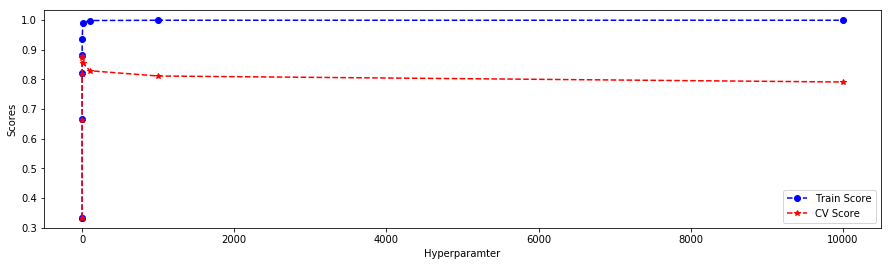

The CV f1-score for each alpha value is :  [0.333 0.333 0.665 0.819 0.873 0.877 0.856 0.829 0.811 0.791]
the Train score for each alpha value is :  [0.333 0.333 0.665 0.822 0.883 0.934 0.991 0.998 0.999 0.999]


In [74]:
# Plotting the performance for L1 Reg

plt.figure(figsize=(15,4))
plt.xlabel('Hyperparamter')
plt.ylabel('Scores')
plt.plot(model.cv_results_['param_C'].data.astype(np.float64), model.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model.cv_results_['param_C'].data.astype(np.float64), model.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV f1-score for each alpha value is : ", np.round(model.cv_results_['mean_test_score'],3))

print("the Train score for each alpha value is : ", np.round(model.cv_results_['mean_train_score'],3))


### [5.10]   Showing how sparsity increases as we increase lambda or decrease C when L1 Regularizer is used in       BoW

By using L1 regularizer we can build a sparse logistic regression and we can compute how many features have been zeroed out because of L1 regularization, as it gives a sparse W vector

In [75]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

import numpy as np

clf = LogisticRegression(C=1000, penalty='l1');  # lambda = 0.001
clf.fit(X_train_bow, Y_train);
w = clf.coef_     # To get the weight vector, we have to do clf.coef( coefficients)
# Count the number of non-zero elements in W. In this case with lambda = 0.001, we got 23953 values
print(np.count_nonzero(w))   


23848


In [76]:
clf = LogisticRegression(C=100, penalty='l1');  # lambda = 0.01
clf.fit(X_train_bow, Y_train);
w = clf.coef_    # To get the weight vector, we have to do clf.coef( coefficients)
# Count the number of non-zero elements in W. In this case with lambda = 0.01, we got 21132 values
print(np.count_nonzero(w))


21046


In [77]:
clf = LogisticRegression(C=10, penalty='l1');  # lambda = 0.1
clf.fit(X_train_bow, Y_train);
w = clf.coef_    # To get the weight vector, we have to do clf.coef( coefficients)
# Count the number of non-zero elements in W. In this case with lambda = 0.01, we got 21132 values
print(np.count_nonzero(w))


16903


In [78]:
clf = LogisticRegression(C=1, penalty='l1');  # Lambda = 1
clf.fit(X_train_bow, Y_train);
w = clf.coef_   # To get the weight vector, we have to do clf.coef( coefficients)
# Count the number of non-zero elements in W. In this case with lambda = 0.01, we got 21132 values
print(np.count_nonzero(w))


6673


In [79]:
clf = LogisticRegression(C=0.1, penalty='l1');  # lambda = 10
clf.fit(X_train_bow, Y_train);
w = clf.coef_    # To get the weight vector, we have to do clf.coef( coefficients)
# Count the number of non-zero elements in W. In this case with lambda = 0.01, we got 21132 values
print(np.count_nonzero(w))


1253


In [80]:
clf = LogisticRegression(C=0.01, penalty='l1');  # lambda = 100
clf.fit(X_train_bow, Y_train);
w = clf.coef_     # To get the weight vector, we have to do clf.coef( coefficients)
# Count the number of non-zero elements in W. In this case with lambda = 0.01, we got 21132 values
print(np.count_nonzero(w))


211


In [81]:
clf = LogisticRegression(C=0.001, penalty='l1'); # lambda = 1000
clf.fit(X_train_bow, Y_train);
w = clf.coef_   # To get the weight vector, we have to do clf.coefficients
print(np.count_nonzero(w))  # Count the number of non-zero elements in W. In this case with lambda = 1000, we got 14 values


15


#### Observation:- 
1. Generally as the lambda increases, the model will be underfit. But with L1 regularizer we get more sparsity.
2. As the lambda increases, the number of non-zero elements decreases, which means sparsity is increasing (number of zero elements increasing.
3. As the lambda decreases, the number of non-zero elements increases, which means sparsity decreases (number of zero elements decreases). 

## [6] TF-IDF

In [148]:
# TF-IDF
# in Scikit-learn
# tf_idf_vect is a variable created 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2)) # 1=unigrams, 2=bi-grams

# 'final_tf_idf' is the sparse matrix in which all of the tf-idf values are stored. 
# fit_transform is a function
X_train_tfidf = tf_idf_vect.fit_transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("the type of TFIDF vectorizer ",type(X_train_tfidf))
print("the type of TFIDF vectorizer ",type(X_test_tfidf))

print(X_train_tfidf.get_shape())
print(X_test_tfidf.get_shape())

print("the number of unique words ", X_train_tfidf.get_shape()[1])
print("the number of unique words ", X_test_tfidf.get_shape()[1])


the type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
(70000, 1374690)
(30000, 1374690)
the number of unique words  1374690
the number of unique words  1374690


In [149]:
# get_feature_names() function is used to get feature names and all are stored in a variable called 'features'
features = tf_idf_vect.get_feature_names()
len(features)

1374690

In [150]:
print("some sample features(unique words in the corpus) are:")
features[50000:50010]

some sample features(unique words in the corpus) are:


['apparentlyso anyone',
 'appart',
 'appart especially',
 'appart first',
 'appart returned',
 'appartently',
 'appartently not',
 'appassionato',
 'appassionato organic',
 'appeal']

In [151]:
def top_tfidf_feats(row, features, top_n=20):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]   # argsort sorts the top 20 tf-idf words for a given review
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

# vector 1 corresponding to review 1 and converting it into a numpy array and giving all feature values and prints the top 20 tf-idf values
top_tfidf = top_tfidf_feats(X_train_tfidf[1,:].toarray()[0],features,20)

In [152]:
top_tfidf

,feature,tfidf
0,laundry,0.152253
1,precription,0.134825
2,jd,0.117135
3,laundry room,0.115896
4,innova,0.095633
5,night,0.095278
6,morning,0.084911
7,food,0.078863
8,lab,0.078036
9,switch,0.070814


### [6.1]  Performing GridSearchCV on TF-IDF using f1-score as metric and L2 regularization

In [153]:
# Performing L2 Regularization
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# GridsearchCV trains the model on these parmters to find the best one
tuned_parameters = [{'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}] # List of parameters for hyperparameter tuning

#Using GridSearchCV. Default regularizer is L2. We can change it to L1 using penalty = 'L1', Giving list of parameters for tuning
# to find best hyperparameter. Now using GridSearchCV, LR model is trained on these list of hyperparameters/values of C.
# Scoring is taken as f1_macro.
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_macro', cv=5)
model.fit(X_train_tfidf, Y_train)

# model.best.estimator prints the best hyperparameter we are looking for and it prints the remaining parameters default 
# as they are, because we performaed GridSearch only for best hyperparameter or C.
print(model.best_estimator_) 


LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [154]:
# to get the score on test data 
print(model.score(X_test_tfidf, Y_test))  


0.907766666564185


In [156]:
# Predicting model on test to find f1-score for L2 reg
from sklearn.metrics import f1_score
logisitc_regression_optimal = LogisticRegression(C = 10000)

# fitting the model
logisitc_regression_optimal.fit(X_train_tfidf, Y_train)

# predict the response
pred_tfidf = logisitc_regression_optimal.predict(X_test_tfidf)

# evaluate accuracy. Using f1_score as metric to measure accuracy
test_f1_tfidf = f1_score(Y_test, pred_tfidf, pos_label = 'positive', average = 'binary') * float(100)
print('\nThe test f1-score of the Logistic regression classifier for TFIDF L2 reg for C = 10000 is %f%%' % (test_f1_tfidf))


The test f1-score of the Logistic regression classifier for TFIDF L2 reg for C = 10000 is 90.776359%


In [157]:
# Finding test error
test_error_tfidf = (1 - f1_score(Y_test, pred_tfidf, pos_label = 'positive', average = 'binary')) 
print("Test Error for Logistic regression TF-IDF for L2 reg is %.3f%%" % (test_error_tfidf))

Test Error for Logistic regression TF-IDF for L2 reg is 0.092%


### [6.2]  Plotting the performance of CV and Train scores for TF-IDF using L2 regularization

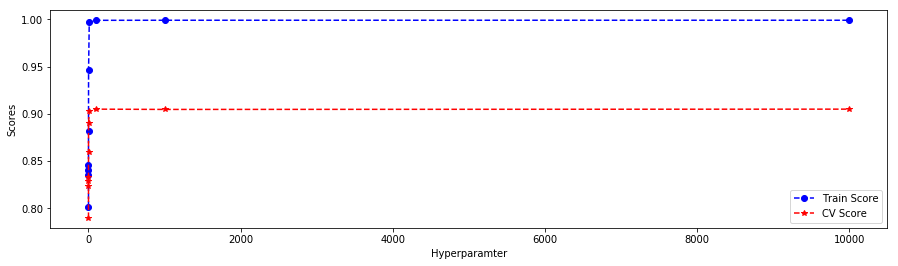

The CV f1-score for each alpha value is :  [0.79  0.824 0.829 0.833 0.86  0.89  0.902 0.905 0.905 0.905]
the Train score for each alpha value is :  [0.801 0.835 0.84  0.846 0.882 0.946 0.997 0.999 0.999 0.999]


In [158]:
# Plotting the performance of CV and Train scores which we got through L2 regularization

plt.figure(figsize=(15,4))
plt.xlabel('Hyperparamter')
plt.ylabel('Scores')
plt.plot(model.cv_results_['param_C'].data.astype(np.float64), model.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model.cv_results_['param_C'].data.astype(np.float64), model.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV f1-score for each alpha value is : ", np.round(model.cv_results_['mean_test_score'],3))

print("the Train score for each alpha value is : ", np.round(model.cv_results_['mean_train_score'],3))


### [6.3]  Plotting ROC curve and finding AUC score for TF-IDF

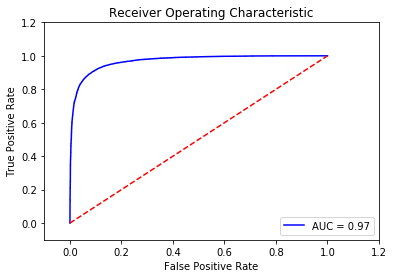

In [159]:
# ROC curve and AUC for TFIDF
from sklearn.metrics import roc_curve, auc
# Predicting the probabilities of test data as ROC curve needs probabilities to plot
Y_prob = model.fit(X_train_tfidf, Y_train).predict_proba(X_test_tfidf)
# Giving actual values(Y_test) and predicted probabilities Y_prob
# we need to calculate the fpr and tpr for all thresholds of the classification 
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob[:, 1], pos_label = 'positive')
# We calculate the AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)
    
# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation:-

From the ROC plot, we got the accuracy of 0.97, which shows that the classifier is working well and predicts correctly.


### [6.4]  Confusion matrix for TF-IDF

In [160]:
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred_tfidf) # finding confusion matrix between true data and predicted data
print(cm)

[[13617  1380]
 [ 1387 13616]]


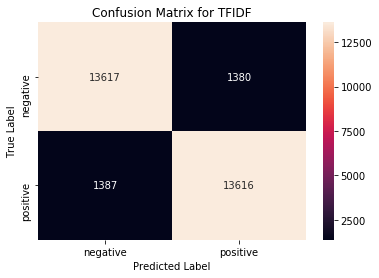

In [161]:
# plot confusion matrix for TF-IDF
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test, pred_tfidf) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Confusion Matrix for TFIDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observations:-

A Confusion matrix is a table that is often used to describe the performance of the classification model on a set of test data. It is also one of the metric to measure accuracy of the model.

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. The confusion matrix shows how the classification model is confused when it makes predictions.

The above confusion matrix is didvided into 2 classes positive and negative with True values and predicted values.

    TN - 13617 , FP - 1380

    FN - 1387 , TP - 13616  
    
    where

    TN - True negative, True value is negative, and is predicted value is negative.
    FP - False positive, True value is negative, but is predicted as positive.
    FN - False negative, True value is positive, but is predicted as negative
    TP - True positive, True value is positive, and is predicted value is positive.

1. There are total of 30000 points being tested against the model. Out of all values, the classifier/model predicted points as positive 14,996 times and negative 15,004 times.
2. But in true values(test data), the positive points are 15,003 and negative points are 14,997.
3. The diagonal values (13617 negative points, 13616 positive points) in the confusion matrix are correctly predicted values by the classifier.



#### Finding TPR, FPR, TNR, FNR values

1.  TPR tells, when it's actually yes and how often does classifier predict yes

    TPR = TP/(TP+FN) = 13616/15003 = 0.9075. TPR also known as Recall


2.  FPR tells, when it's actually no, how often does classifier predict yes

    FPR = FP/(FP+TN) = 1380/14997 = 0.0937


3.  TNR tells, when it's actually no, how often does classifier predict no

    TNR = TN/(TN+FP) = 13617/14997 = 0.9079


4.  FNR tells, When it's actually yes, how often does it predict no

    FNR = FN/(FN+TP) = 1387/15003 = 0.0924



### [6.5]  Classification report for TF-IDF:-

1. Classification Rate/Accuracy:

   Accuracy = (TP + TN) / (TP + TN + FP + FN)


2. Recall:- It tells, when the points are positive and how often they are predicted positive.

   Recall = TP / (TP + FN)


3. Precision:- It tells, when the model predicted positive and how often is it correct.

   Precision = TP / (TP + FP)


4. f1-score = (2 Recall Precision) / (Recall + Presision)


5. Support is the total number of points in each class (positive and negative)


In [162]:
# calculate the classification report for TF-IDF
from sklearn.metrics import classification_report 
 
print('Accuracy Score:', accuracy_score(Y_test, pred_tfidf)) 
print('Report:')
print(classification_report(Y_test, pred_tfidf)) 


Accuracy Score: 0.9077666666666667
Report:
             precision    recall  f1-score   support

   negative       0.91      0.91      0.91     14997
   positive       0.91      0.91      0.91     15003

avg / total       0.91      0.91      0.91     30000



### [6.6]  Feature Importance for TF-IDF


To find feature Importance, first sort all the words based on its absolute value of feature weight score, where top words have more weight. So for positive class or negative class, we have to find words with highest absolute weight value, as they are most informative/important features or words for determining whether the text/sentence belongs to positive class or negative class.

If the weight value of a word is positive and large then probability that the word/feature belongs to positive class increases. If the weight value of a word is negative and large then probability that the word/feature belongs to negative class increases.

So we can say that, in Logistic regression we can find feature importance based on absolute value of feature weights.

In [163]:
feature_names = np.array(tf_idf_vect.get_feature_names())

model = LogisticRegression()
model.fit(X_train_tfidf, Y_train)

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['not' 'disappointed' 'not good' 'worst' 'awful' 'terrible'
 'disappointing' 'not buy' 'horrible' 'bad']

Largest Coefs: 
['great' 'best' 'delicious' 'good' 'perfect' 'love' 'excellent'
 'wonderful' 'loves' 'nice']



In [167]:
# Reference:--  https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def show_most_informative_features(vectorizer, model, n=10): # To print top 10 features 
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(model.coef_[0], feature_names)) # fns- feature names
    top = zip(coefs_with_fns[:-(n + 1):-1], coefs_with_fns[:n]) 
    for (coef_1, fn_1), (coef_0, fn_0) in top:  # For positive and negative classes to print top 10 features
        print("\t%.4f \t%-15s \t\t%.4f \t%-15s" % (coef_1, fn_1, coef_0, fn_0))
show_most_informative_features(tf_idf_vect, model)


	15.6703 	great           		-12.7051 	not            
	12.3164 	best            		-11.6281 	disappointed   
	11.6052 	delicious       		-8.7051 	not good       
	9.7468 	good            		-8.3183 	worst          
	9.6543 	perfect         		-7.3266 	awful          
	9.4453 	love            		-7.2922 	terrible       
	8.8744 	excellent       		-7.1076 	disappointing  
	8.1462 	wonderful       		-7.1034 	not buy        
	8.0952 	loves           		-7.0111 	horrible       
	7.7237 	nice            		-6.6569 	bad            


## L1 Regularization for TF-IDF

In [98]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

# GridsearchCV trains the model on these parmters to find the best one
tuned_parameters = [{'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}] # List of parameters for hyperparameter tuning

#Using GridSearchCV. Default regularizer is L2. We can change it to L1 using penalty = 'L1', Giving list of parameters for tuning
# to find best hyperparameter. Now using GridSearchCV, LR model is trained on these list of hyperparameters/values of C.
# Scoring is taken as f1_macro.
model = GridSearchCV(LogisticRegression(penalty='l1', class_weight="balanced"), tuned_parameters, scoring = 'f1_macro', cv=5)
model.fit(X_train_tfidf, Y_train)


# model.best.estimator prints the best hyperparameter we are looking for and it prints the remaining parameters default 
# as they are, because we performaed GridSearch only for best hyperparameter or C.
print(model.best_estimator_) 


LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [99]:
print(model.score(X_test_tfidf, Y_test))

0.9004662946317945


In [100]:
# Predicting model on test to find f1-score for L1 reg
from sklearn.metrics import f1_score
logisitc_regression_optimal = LogisticRegression(C = 10)

# fitting the model
logisitc_regression_optimal.fit(X_train_tfidf, Y_train)

# predict the response
pred_tfidf = logisitc_regression_optimal.predict(X_test_tfidf)

# evaluate accuracy. Using f1_score as metric to measure accuracy
test_f1_tfidf = f1_score(Y_test, pred_tfidf, pos_label = 'positive', average = 'binary') * float(100)
print('\nThe test f1-score of the Logistic regression classifier using L1 reg for C = 10 is %f%%' % (test_f1_tfidf))


The test f1-score of the Logistic regression classifier using L1 reg for C = 10 is 90.680908%


In [101]:
# Finding test error
test_error_tfidf = (1 - f1_score(Y_test, pred_tfidf, pos_label = 'positive', average = 'binary')) 
print("Test Error for Logistic regression TF-IDF using L1 reg is %.3f%%" % (test_error_tfidf))

Test Error for Logistic regression TF-IDF using L1 reg is 0.093%


### [6.7]  Plotting the performance of CV and Train scores for TF-IDF using L1 regularization

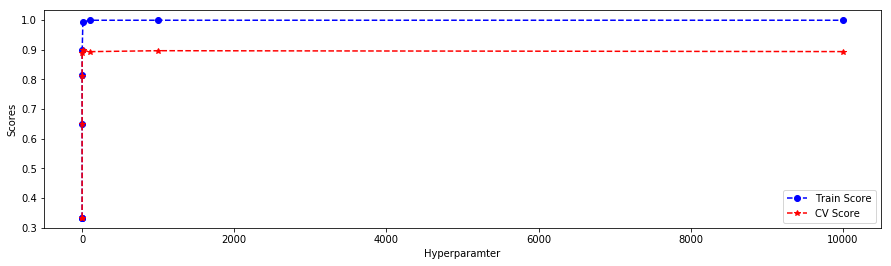

The CV f1-score for each alpha value is :  [0.333 0.333 0.333 0.649 0.812 0.888 0.898 0.893 0.896 0.893]
the Train score for each alpha value is :  [0.333 0.333 0.333 0.649 0.813 0.897 0.993 0.999 0.999 0.999]


In [102]:
# Plotting the performance for TF-IDF using L1 regularization

plt.figure(figsize=(15,4))
plt.xlabel('Hyperparamter')
plt.ylabel('Scores')
plt.plot(model.cv_results_['param_C'].data.astype(np.float64), model.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model.cv_results_['param_C'].data.astype(np.float64), model.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV f1-score for each alpha value is : ", np.round(model.cv_results_['mean_test_score'],3))

print("the Train score for each alpha value is : ", np.round(model.cv_results_['mean_train_score'],3))


## [7]  Word2Vec

In [168]:
# I am Training Word2Vec model using Amazon fine food text corpus
# This is W2V for Train data
# We are creating a list of sentences
# list_of_sent is created to store sentences
i=0
list_of_sent_train=[]
for sent in X_train:
    list_of_sent_train.append(sent.split())

In [169]:
# One sentence is converted into a list
print(X_train.values[0])
print("*****************************************************************")
print(list_of_sent_train[0])

reason bought hershey amores bar cannot find anywhere received bars no amores bars instead given take bars going try send back receive refund
*****************************************************************
['reason', 'bought', 'hershey', 'amores', 'bar', 'cannot', 'find', 'anywhere', 'received', 'bars', 'no', 'amores', 'bars', 'instead', 'given', 'take', 'bars', 'going', 'try', 'send', 'back', 'receive', 'refund']


In [170]:
# Train the word2vec model for Train data
# min_count=5 says, if the word doesn't occur atleast 5 times then don't construct w2v for it
# size=50 says about the dimension of the vector
# we are storing Word2Vec model in w2v_model
import gensim
w2v_model_train = gensim.models.Word2Vec(list_of_sent_train, min_count=5, size=50, workers=4)

# we can get dictionary of all the words that we have
# we are storing Word2Vec model in w2v_model
words_train = list(w2v_model_train.wv.vocab)
print(len(words_train))

# prints 50 words
print("sample words ", words_train[0:50])

17713
sample words  ['reason', 'bought', 'hershey', 'amores', 'bar', 'cannot', 'find', 'anywhere', 'received', 'bars', 'no', 'instead', 'given', 'take', 'going', 'try', 'send', 'back', 'receive', 'refund', 'happy', 'read', 'good', 'reviews', 'gradual', 'switch', 'last', 'evening', 'cole', 'great', 'dane', 'lab', 'mix', 'really', 'liked', 'innova', 'kept', 'around', 'corner', 'laundry', 'room', 'food', 'snap', 'shut', 'box', 'old', 'new', 'thought', 'keep', 'door']


In [106]:
w2v_model_train.wv.most_similar('family')

[('household', 0.7172931432723999),
 ('members', 0.7165572047233582),
 ('member', 0.6632149815559387),
 ('friends', 0.6623551845550537),
 ('hubby', 0.6557009220123291),
 ('husband', 0.6462013721466064),
 ('mom', 0.6444351673126221),
 ('relatives', 0.6416627764701843),
 ('dad', 0.6321682929992676),
 ('raved', 0.6310843229293823)]

In [171]:
# This is W2V for Test data
# We are creating a list of sentences
# list_of_sent is created to store sentences
i=0
list_of_sent_test=[]
for sent in X_test:
    list_of_sent_test.append(sent.split())
    

In [172]:
# One sentence is converted into a list
print(X_test.values[0])
print("*****************************************************************")
print(list_of_sent_test[0])

beware small bars nearly many calories fat candy bartaste chocolate coconut chew variety best described bittersweet cocoa mixed lard
*****************************************************************
['beware', 'small', 'bars', 'nearly', 'many', 'calories', 'fat', 'candy', 'bartaste', 'chocolate', 'coconut', 'chew', 'variety', 'best', 'described', 'bittersweet', 'cocoa', 'mixed', 'lard']


In [173]:
# Train the word2vec model for Test data
# min_count=5 says, if the word doesn't occur atleast 5 times then don't construct w2v for it
# size=50 says about the dimension of the vector
# we are storing Word2Vec model in w2v_model
import gensim
w2v_model_test = gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

# we can get dictionary of all the words that we have
# we are storing Word2Vec model in w2v_model
words_test = list(w2v_model_test.wv.vocab)
print(len(words_test))

# prints 50 words
print("sample words ", words_test[0:50])

11358
sample words  ['beware', 'small', 'bars', 'nearly', 'many', 'calories', 'fat', 'candy', 'chocolate', 'coconut', 'chew', 'variety', 'best', 'described', 'bittersweet', 'cocoa', 'mixed', 'lard', 'tea', 'received', 'cheaper', 'version', 'en', 'green', 'not', 'crop', 'type', 'shown', 'photo', 'misleading', 'unhappy', 'want', 'deal', 'stupid', 'return', 'system', 'amazon', 'no', 'time', 'itdo', 'recommend', 'buying', 'using', 'hair', 'oil', 'years', 'realized', 'mineral', 'petroleum', 'product']


In [110]:
w2v_model_test.wv.most_similar('like')

[('okay', 0.7167751789093018),
 ('weird', 0.6986594796180725),
 ('gross', 0.6865251064300537),
 ('nasty', 0.6786848902702332),
 ('similar', 0.6691201329231262),
 ('awful', 0.6601837277412415),
 ('ok', 0.6489063501358032),
 ('bland', 0.6483946442604065),
 ('terrible', 0.6477005481719971),
 ('disgusting', 0.643695592880249)]

In [111]:
# list of words in BoW
count_vect_feat = count_vect.get_feature_names()
print(len(count_vect_feat))

95408


In [112]:
count_vect_feat.index('like')

47186

In [114]:
print(count_vect_feat[47186])

like


### [7.1]  Avg-Word2Vec

We take the average of all word2vec(vector) representations of all words in a review and divide them by number of words in a review. This is vector representation of a review. 

In [174]:
# average Word2Vec for Train data
# compute average word2vec for each review.
from tqdm import tqdm
#List to store all the avg w2vec's 
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # to count num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_train:
            vec = w2v_model_train.wv[word] # vector of each word using w2v model
            sent_vec += vec # Adding the vectors
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words  # Taking average of vectors sum of the particular review
    sent_vectors_train.append(sent_vec)  # Storing the avg w2vec's for each review in the list
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

70000
50


In [175]:
# average Word2Vec for Test data
# compute average word2vec for each review.
from tqdm import tqdm
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
50


### [7.2]  Performing GridSearch CV on AvgW2V using f1-score as metric using L2 regularization

In [117]:

# Performing L2 Regularization
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# GridsearchCV trains the model on these parmters to find the best one
tuned_parameters = [{'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}] # List of parameters for hyperparameter tuning

#Using GridSearchCV. Default regularizer is L2. We can change it to L1 using penalty = 'L1', Giving list of parameters for tuning
# to find best hyperparameter. Now using GridSearchCV, LR model is trained on these list of hyperparameters/values of C.
# Scoring is taken as f1_macro.
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_macro', cv=5)
model.fit(sent_vectors_train, Y_train)


# model.best.estimator prints the best hyperparameter we are looking for and it prints the remaining parameters default 
# as they are, because we performaed GridSearch only for best hyperparameter or C.
print(model.best_estimator_) 


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [118]:
# to get the score on test data 
print(model.score(sent_vectors_test, Y_test))  


0.7874533560407926


In [119]:
# Predicting model on test to find f1-score
from sklearn.metrics import f1_score
logisitc_regression_optimal = LogisticRegression(C = 0.1)

# fitting the model
logisitc_regression_optimal.fit(sent_vectors_train, Y_train)

# predict the response
pred_w2v = logisitc_regression_optimal.predict(sent_vectors_test)

# evaluate accuracy. Using f1_score as metric to measure accuracy
test_f1_w2v = f1_score(Y_test, pred_w2v, pos_label = 'positive', average = 'binary') * float(100)
print('\nThe test f1-score of the Logistic regression classifier AvgW2V for C = 0.1 is %f%%' % (test_f1_w2v))


The test f1-score of the Logistic regression classifier AvgW2V for C = 0.1 is 78.187046%


In [120]:
# Finding test error
test_error_w2v = (1 - f1_score(Y_test, pred_w2v, pos_label = 'positive', average = 'binary')) 
print("Test Error for Logistic regression AvgW2v is %.3f%%" % (test_error_w2v))

Test Error for Logistic regression AvgW2v is 0.218%


### [7.3] Plotting the performance of CV and Train scores for AvgW2V for L2 regularization

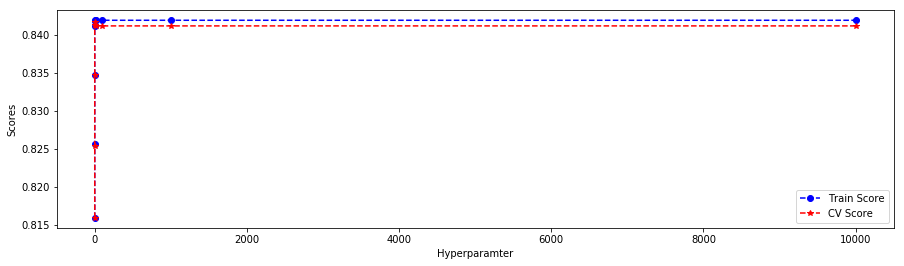

The CV f1-score for each alpha value is :  [0.816 0.825 0.835 0.841 0.842 0.841 0.841 0.841 0.841 0.841]
the Train score for each alpha value is :  [0.816 0.826 0.835 0.841 0.842 0.842 0.842 0.842 0.842 0.842]


In [121]:
# Plotting the performance of CV and Train scores which we got through L2 regularization

plt.figure(figsize=(15,4))
plt.xlabel('Hyperparamter')
plt.ylabel('Scores')
plt.plot(model.cv_results_['param_C'].data.astype(np.float64), model.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model.cv_results_['param_C'].data.astype(np.float64), model.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV f1-score for each alpha value is : ", np.round(model.cv_results_['mean_test_score'],3))

print("the Train score for each alpha value is : ", np.round(model.cv_results_['mean_train_score'],3))

### [7.4] Plotting ROC curve and finding AUC score for AvgW2V

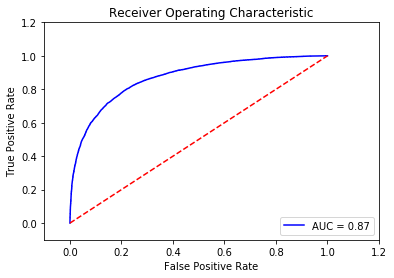

In [122]:
# ROC curve and AUC for AvgW2V
from sklearn.metrics import roc_curve, auc
# Predicting the probabilities of test data as ROC curve needs probabilities to plot
Y_prob = model.fit(sent_vectors_train, Y_train).predict_proba(sent_vectors_test)
# Giving actual values(Y_test) and predicted probabilities Y_prob
# we need to calculate the fpr and tpr for all thresholds of the classification 
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob[:, 1], pos_label = 'positive')
# We calculate the AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)
    
# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation:-
From the ROC plot, we got the accuracy of 0.87

### [7.5]  Confusion matrix for AvgW2V

In [123]:
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred_w2v) # finding confusion matrix between true data and predicted data
print(cm)

[[12208  2789]
 [ 3583 11420]]


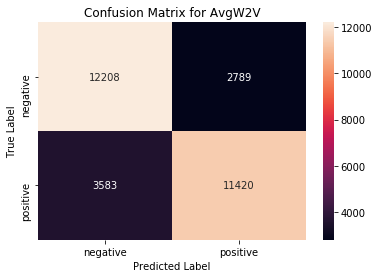

In [124]:
# plot confusion matrix for AvgW2V
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test, pred_w2v) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Confusion Matrix for AvgW2V")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observations:-

A Confusion matrix is a table that is often used to describe the performance of the classification model on a set of test data. It is also one of the metric to measure accuracy of the model.

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. The confusion matrix shows how the classification model is confused when it makes predictions.

The above confusion matrix is didvided into 2 classes positive and negative with True values and predicted values.

TN - 12208 , FP - 2789

FN - 3583 , TP - 11420

where

TN - True negative, True value is negative, and is predicted value is negative.
FP - False positive, True value is negative, but is predicted as positive.
FN - False negative, True value is positive, but is predicted as negative
TP - True positive, True value is positive, and is predicted value is positive.

1. There are total of 30000 points being tested against the model. Out of all values, the classifier/model predicted points as positive 14,209 times and negative 15,791 times.
2. But in true values(test data), the positive points are 15,003 and negative points are 14,997.
3. The diagonal values (12208 negative points, 11420 positive points) in the confusion matrix are correctly predicted values by the classifier.


#### Finding TPR, FPR, TNR, FNR values

1. TPR tells, when it's actually yes and how often does classifier predict yes

   TPR = TP/(TP+FN) . TPR also known as Recall


2. FPR tells, when it's actually no, how often does classifier predict yes

   FPR = FP/(FP+TN) 


3. TNR tells, when it's actually no, how often does classifier predict no

   TNR = TN/(TN+FP) 


4. FNR tells, When it's actually yes, how often does it predict no

   FNR = FN/(FN+TP) 


### [7.6] Classification report for AvgW2V:-

1. Classification Rate/Accuracy:

   Accuracy = (TP + TN) / (TP + TN + FP + FN)


2. Recall:- It tells, when the points are positive and how often they are predicted positive.

   Recall = TP / (TP + FN)


3. Precision:- It tells, when the model predicted positive and how often is it correct.

   Precision = TP / (TP + FP)


4. f1-score = (2 Recall Precision) / (Recall + Presision)


5. Support is the total number of points in each class (positive and negative)


In [125]:
# calculate the classification report for AvgW2V
from sklearn.metrics import classification_report 
 
print('Accuracy Score:', accuracy_score(Y_test, pred_w2v)) 
print('Report:')
print(classification_report(Y_test, pred_w2v)) 


Accuracy Score: 0.7876
Report:
             precision    recall  f1-score   support

   negative       0.77      0.81      0.79     14997
   positive       0.80      0.76      0.78     15003

avg / total       0.79      0.79      0.79     30000



## L1 Regularization for Avg W2V

In [176]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

# GridsearchCV trains the model on these parmters to find the best one
tuned_parameters = [{'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}] # List of parameters for hyperparameter tuning

#Using GridSearchCV. Default regularizer is L2. We can change it to L1 using penalty = 'L1', Giving list of parameters for tuning
# to find best hyperparameter. Now using GridSearchCV, LR model is trained on these list of hyperparameters/values of C.
# Scoring is taken as f1_macro.
model = GridSearchCV(LogisticRegression(penalty='l1', class_weight="balanced"), tuned_parameters, scoring = 'f1_macro', cv=5)
model.fit(sent_vectors_train, Y_train)


# model.best.estimator prints the best hyperparameter we are looking for and it prints the remaining parameters default 
# as they are, because we performaed GridSearch only for best hyperparameter or C.
print(model.best_estimator_) 


LogisticRegression(C=10000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [177]:
# to get the score on test data 
print(model.score(sent_vectors_test, Y_test)) 

0.7573189498687143


In [178]:
# Predicting model on test to find f1-score L1 reg
from sklearn.metrics import f1_score
logisitc_regression_optimal = LogisticRegression(C = 10000)

# fitting the model
logisitc_regression_optimal.fit(sent_vectors_train, Y_train)

# predict the response
pred_w2v = logisitc_regression_optimal.predict(sent_vectors_test)

# evaluate accuracy. Using f1_score as metric to measure accuracy
test_f1_w2v = f1_score(Y_test, pred_w2v, pos_label = 'positive', average = 'binary') * float(100)
print('\nThe test f1-score of the Logistic regression classifier AvgW2V for C = 10000 is %f%%' % (test_f1_w2v))


The test f1-score of the Logistic regression classifier AvgW2V for C = 10000 is 72.396796%


In [180]:
# Finding test error
test_error_w2v = (1 - f1_score(Y_test, pred_w2v, pos_label = 'positive', average = 'binary')) 
print("Test Error for Logistic regression AvgW2v L1 Reg is %.3f%%" % (test_error_w2v))

Test Error for Logistic regression AvgW2v L1 Reg is 0.276%


### [7.7]  Plotting the performance of CV and Train scores for L1 regularization for AvgW2V 

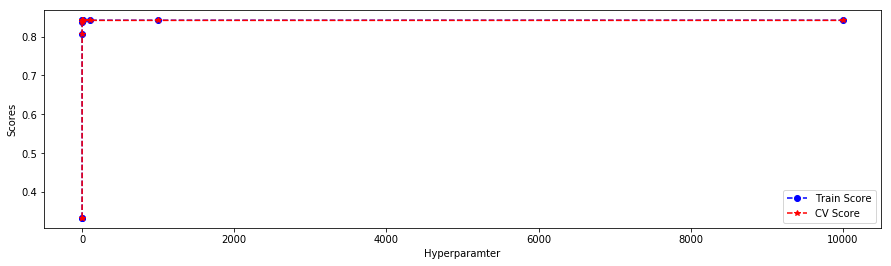

The CV f1-score for each alpha value is :  [0.333 0.333 0.806 0.838 0.842 0.842 0.842 0.842 0.842 0.842]
the Train score for each alpha value is :  [0.333 0.333 0.807 0.838 0.842 0.842 0.842 0.842 0.842 0.842]


In [181]:
# Plotting the performance of CV and Train scores which we got through L1 regularization

plt.figure(figsize=(15,4))
plt.xlabel('Hyperparamter')
plt.ylabel('Scores')
plt.plot(model.cv_results_['param_C'].data.astype(np.float64), model.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model.cv_results_['param_C'].data.astype(np.float64), model.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV f1-score for each alpha value is : ", np.round(model.cv_results_['mean_test_score'],3))

print("the Train score for each alpha value is : ", np.round(model.cv_results_['mean_train_score'],3))

## [8]  TFIDF-W2V

In [182]:
model = TfidfVectorizer()
tfidf_train_matrix = model.fit_transform(X_train)
tfidf_test_matrix = model.transform(X_test)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [183]:
print(tfidf_train_matrix.get_shape()) 
print(tfidf_test_matrix.get_shape()) 


(70000, 95408)
(30000, 95408)


In [184]:
# TF-IDF weighted Word2Vec for Train data

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_train:
            try:
                vec = w2v_model_train.wv[word]
            # tf_idf = tfidf_train_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 70000/70000 [05:39<00:00, 205.92it/s]


In [185]:
# TF-IDF weighted Word2Vec for Test data

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_test:
            try:
                vec = w2v_model_test.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            #tf_idf = tfidf_test_matrix[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [01:37<00:00, 306.65it/s]


### [8.1]  Performing GridSearch CV on TFIDF-W2V using f1-score as metric with L2 regularization

In [186]:

# Performing L2 Regularization
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# GridsearchCV trains the model on these parmters to find the best one
tuned_parameters = [{'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}] # List of parameters for hyperparameter tuning

#Using GridSearchCV. Default regularizer is L2. We can change it to L1 using penalty = 'L1', Giving list of parameters for tuning
# to find best hyperparameter. Now using GridSearchCV, LR model is trained on these list of hyperparameters/values of C.
# Scoring is taken as f1_macro.
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_macro', cv=5)
model.fit(tfidf_sent_vectors_train, Y_train)


# model.best.estimator prints the best hyperparameter we are looking for and it prints the remaining parameters default 
# as they are, because we performaed GridSearch only for best hyperparameter or C.
print(model.best_estimator_) 


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [187]:
# to get the score on test data 

print(model.score(tfidf_sent_vectors_test, Y_test))  


0.7557357762465657


In [188]:
# Predicting model on test to find f1-score for L2 reg
from sklearn.metrics import f1_score
logisitc_regression_optimal = LogisticRegression(C = 0.01)

# fitting the model
logisitc_regression_optimal.fit(tfidf_sent_vectors_train, Y_train)

# predict the response
pred_tfidf_w2v = logisitc_regression_optimal.predict(tfidf_sent_vectors_test)

# evaluate accuracy. Using f1_score as metric to measure accuracy
test_f1_tfidf_w2v = f1_score(Y_test, pred_tfidf_w2v, pos_label = 'positive', average = 'binary') * float(100)
print('\nThe test f1-score of the Logistic regression classifier TFIDF-W2V for C = 0.01 is %f%%' % (test_f1_tfidf_w2v))


The test f1-score of the Logistic regression classifier TFIDF-W2V for C = 0.01 is 73.660989%


In [189]:
# Finding test error
test_error_tfidf_w2v = (1 - f1_score(Y_test, pred_tfidf_w2v, pos_label = 'positive', average = 'binary')) 
print("Test Error for Logistic regression TFIDF-W2V L2 reg is %.3f%%" % (test_error_tfidf_w2v))

Test Error for Logistic regression TFIDF-W2V L2 reg is 0.263%


### [8.2]  Plotting the performance of CV and Train scores for TFIDF-W2V  L2 regularization 

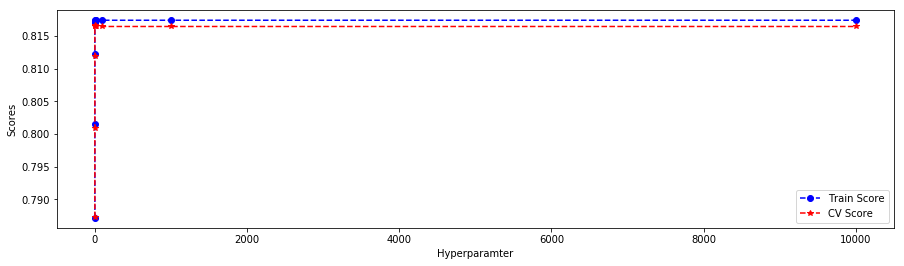

The CV f1-score for each alpha value is :  [0.787 0.801 0.812 0.817 0.817 0.817 0.816 0.816 0.816 0.816]
the Train score for each alpha value is :  [0.787 0.801 0.812 0.817 0.817 0.817 0.817 0.817 0.817 0.817]


In [190]:
# Plotting the performance of CV and Train scores which we got through L2 regularization

plt.figure(figsize=(15,4))
plt.xlabel('Hyperparamter')
plt.ylabel('Scores')
plt.plot(model.cv_results_['param_C'].data.astype(np.float64), model.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model.cv_results_['param_C'].data.astype(np.float64), model.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV f1-score for each alpha value is : ", np.round(model.cv_results_['mean_test_score'],3))

print("the Train score for each alpha value is : ", np.round(model.cv_results_['mean_train_score'],3))


### [8.3] Plotting ROC curve and finding AUC score for TFIDF-W2V

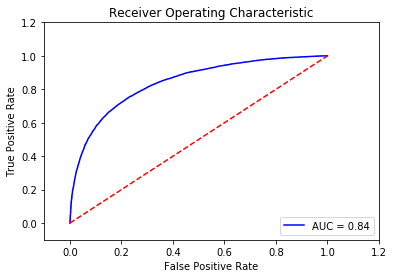

In [191]:
# ROC curve and AUC for TFIDF-W2V
from sklearn.metrics import roc_curve, auc
# Predicting the probabilities of test data as ROC curve needs probabilities to plot
Y_prob = model.fit(tfidf_sent_vectors_train, Y_train).predict_proba(tfidf_sent_vectors_test)
# Giving actual values(Y_test) and predicted probabilities Y_prob
# we need to calculate the fpr and tpr for all thresholds of the classification 
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob[:, 1], pos_label = 'positive')
# We calculate the AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)
    
# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation:-

From the ROC plot, we got the accuracy of 0.84 

### [8.4]  Confusion matrix for TFIDF-W2V

In [192]:
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred_tfidf_w2v) # finding confusion matrix between true data and predicted data
print(cm)

[[12533  2464]
 [ 4819 10184]]


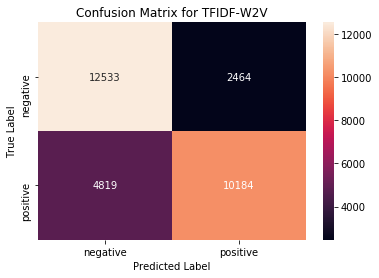

In [193]:
# plot confusion matrix for TFIDF-W2V
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test, pred_tfidf_w2v) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Confusion Matrix for TFIDF-W2V")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observations:-

A Confusion matrix is a table that is often used to describe the performance of the classification model on a set of test data. It is also one of the metric to measure accuracy of the model.

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. The confusion matrix shows how the classification model is confused when it makes predictions.

The above confusion matrix is didvided into 2 classes positive and negative with True values and predicted values.

TN - 12533 , FP - 2464

FN - 4819 ,  TP - 10184

where

TN - True negative, True value is negative, and is predicted value is negative.
FP - False positive, True value is negative, but is predicted as positive.
FN - False negative, True value is positive, but is predicted as negative
TP - True positive, True value is positive, and is predicted value is positive.

1. There are total of 30000 points being tested against the model. Out of all values, the classifier/model predicted points as positive 12,648 times and negative 17,352 times.
2. But in true values(test data), the positive points are 15,003 and negative points are 14,997.
3. The diagonal values (12533 negative points, 10184 positive points) in the confusion matrix are correctly predicted values by the classifier.


#### Finding TPR, FPR, TNR, FNR values

1. TPR tells, when it's actually yes and how often does classifier predict yes

   TPR = TP/(TP+FN) . TPR also known as Recall


2. FPR tells, when it's actually no, how often does classifier predict yes

   FPR = FP/(FP+TN) 


3. TNR tells, when it's actually no, how often does classifier predict no

   TNR = TN/(TN+FP) 


4. FNR tells, When it's actually yes, how often does it predict no

   FNR = FN/(FN+TP) 


### [8.5] Classification report for TFIDF-W2V:-

1. Classification Rate/Accuracy:

   Accuracy = (TP + TN) / (TP + TN + FP + FN)


2. Recall:- It tells, when the points are positive and how often they are predicted positive.
  
   Recall = TP / (TP + FN)


3. Precision:- It tells, when the model predicted positive and how often is it correct.

   Precision = TP / (TP + FP)


4. f1-score = (2 Recall Precision) / (Recall + Presision)


5. Support is the total number of points in each class (positive and negative)


In [194]:
# calculate the classification report for TFIDF-W2V
from sklearn.metrics import classification_report 
 
print('Accuracy Score:', accuracy_score(Y_test, pred_tfidf_w2v)) 
print('Report:')
print(classification_report(Y_test, pred_tfidf_w2v)) 


Accuracy Score: 0.7572333333333333
Report:
             precision    recall  f1-score   support

   negative       0.72      0.84      0.77     14997
   positive       0.81      0.68      0.74     15003

avg / total       0.76      0.76      0.76     30000



## L1 Regularization for TFIDF-AvgW2V

In [195]:
# Performing L1 Regularization
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# GridsearchCV trains the model on these parmters to find the best one
tuned_parameters = [{'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}] # List of parameters for hyperparameter tuning

#Using GridSearchCV. Default regularizer is L2. We can change it to L1 using penalty = 'L1', Giving list of parameters for tuning
# to find best hyperparameter. Now using GridSearchCV, LR model is trained on these list of hyperparameters/values of C.
# Scoring is taken as f1_macro.
model = GridSearchCV(LogisticRegression(penalty='l1', class_weight="balanced"), tuned_parameters, scoring = 'f1_macro', cv=5)
model.fit(tfidf_sent_vectors_train, Y_train)


# model.best.estimator prints the best hyperparameter we are looking for and it prints the remaining parameters default 
# as they are, because we performaed GridSearch only for best hyperparameter or C.
print(model.best_estimator_) 


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [196]:
# to get the score on test data 

print(model.score(tfidf_sent_vectors_test, Y_test))  


0.7466632535866398


In [197]:
# Predicting model on test to find f1-score
from sklearn.metrics import f1_score
logisitc_regression_optimal = LogisticRegression(C = 0.1)

# fitting the model
logisitc_regression_optimal.fit(tfidf_sent_vectors_train, Y_train)

# predict the response
pred_tfidf_w2v = logisitc_regression_optimal.predict(tfidf_sent_vectors_test)

# evaluate accuracy. Using f1_score as metric to measure accuracy
test_f1_tfidf_w2v = f1_score(Y_test, pred_tfidf_w2v, pos_label = 'positive', average = 'binary') * float(100)
print('\nThe test f1-score of the Logistic regression classifier TFIDF-W2V L1 reg for C = 0.1 is %f%%' % (test_f1_tfidf_w2v))


The test f1-score of the Logistic regression classifier TFIDF-W2V L1 reg for C = 0.1 is 71.555855%


In [198]:
# Finding test error
test_error_tfidf_w2v = (1 - f1_score(Y_test, pred_tfidf_w2v, pos_label = 'positive', average = 'binary')) 
print("Test Error for Logistic regression TFIDF-W2V L1 reg is %.3f%%" % (test_error_tfidf_w2v))

Test Error for Logistic regression TFIDF-W2V L1 reg is 0.284%


### [8.6]  Plotting the performance of CV and Train scores for TFIDF-W2V for L1 regularization

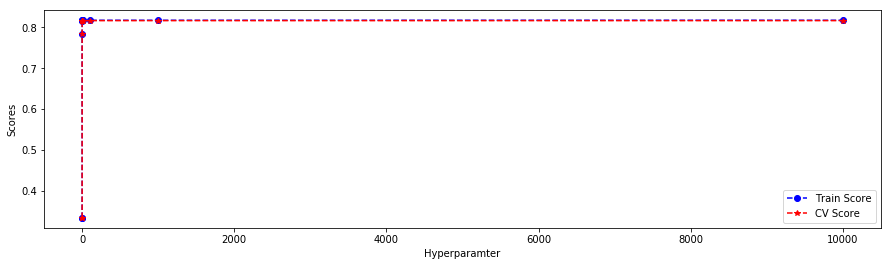

The CV f1-score for each alpha value is :  [0.333 0.333 0.783 0.815 0.817 0.817 0.817 0.816 0.816 0.817]
the Train score for each alpha value is :  [0.333 0.333 0.784 0.816 0.817 0.817 0.817 0.817 0.817 0.817]


In [199]:
# Plotting the performance of CV and Train scores which we got through L1 regularization

plt.figure(figsize=(15,4))
plt.xlabel('Hyperparamter')
plt.ylabel('Scores')
plt.plot(model.cv_results_['param_C'].data.astype(np.float64), model.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model.cv_results_['param_C'].data.astype(np.float64), model.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV f1-score for each alpha value is : ", np.round(model.cv_results_['mean_test_score'],3))

print("the Train score for each alpha value is : ", np.round(model.cv_results_['mean_train_score'],3))


## [9]  Models Summarization

In [225]:
from pandas import DataFrame
LogisticRegression = {'Vectorizer':['BoW', 'TFIDF', 'AVG-W2V', 'TFIDF-W2V'], 'Model':['Logistic_Regression','Logistic_Regression','Logistic_Regression','Logistic_Regression'], 
                       'Hyper parameter C for L1 Reg':['1', '10','10000','0.1'],
                       'F1-score for L1 Reg':['88.24','90.68','72.39','71.55'],
                       'Test error for L1 Reg':['0.11','0.09','0.27','0.28'],
                       'Hyper parameter C for L2 Reg':['0.1','10000','0.1','0.01'],
                       'F1-score for L2 Reg':['88.56','90.77','78.18','73.66'],
                       'Test error for L2 Reg':['0.114','0.092','0.218','0.263'],
                       'AUC Score':['0.95','0.97','0.87','0.84']}
                       

In [226]:
Final_conclusions = DataFrame(LogisticRegression)
Final_conclusions

,Vectorizer,Model,Hyper parameter C for L1 Reg,F1-score for L1 Reg,Test error for L1 Reg,Hyper parameter C for L2 Reg,F1-score for L2 Reg,Test error for L2 Reg,AUC Score
0,BoW,Logistic_Regression,1,88.24,0.11,0.1,88.56,0.114,0.95
1,TFIDF,Logistic_Regression,10,90.68,0.09,10000,90.77,0.092,0.97
2,AVG-W2V,Logistic_Regression,10000,72.39,0.27,0.1,78.18,0.218,0.87
3,TFIDF-W2V,Logistic_Regression,0.1,71.55,0.28,0.01,73.66,0.263,0.84


## [10] Conclusions:-

1. From the above observations we can say that, f1-score is better for Logistic Regression using L2 Regularization for all the featurizations.
2. Logistic Regression of TF-IDF gave more f1-score than the other featurizations.
3. TF-IDF has more AUC score of 0.97, which shows that model is working well.
4. Overall models BoW and TFIDF trained by Logistic Regression are working well on unseen data than the AvgW2V and TFIDF-W2V.